# Построение модели классификации полноразмерных изображений: распознавание кошек и собак на фотографиях

In [ ]:
import os
import shutil
import numpy as np
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator    # Генератор обучающих данных
from tensorflow.keras.models import Sequential      # Контейнер модели
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization  # Типы используемых слоев
from tensorflow.keras.optimizers import Adam    # Алгоритм оптимизации
import matplotlib.pyplot as plt
from zipfile import ZipFile

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
zip_path = "/content/drive/MyDrive/Лекция 2. Cats and dogs, dropout, ViT/dataset.zip"
# Путь к локальному сессионному хранилищу
LOCAL_DIR = '/content'

# Распаковка архива в сессионное хранилище
with ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall()

In [ ]:
# Если архив уже распакован на Google диск, то можно скопировать его в сессионное хранилище
# Сохраняем путь к папке на Google Drive в переменную DRIVE_DIR
DRIVE_DIR = '/content/drive/MyDrive/Лекция 2. Cats and dogs, dropout, ViT/dataset'

# Копируем выборку в сессионное хранилище
shutil.copytree(DRIVE_DIR, os.path.join(LOCAL_DIR, 'dataset'))

In [ ]:
# Проверяем количество изображений
len(os.listdir(os.path.join(LOCAL_DIR, 'dataset', 'train', '0 - cats')))

2000

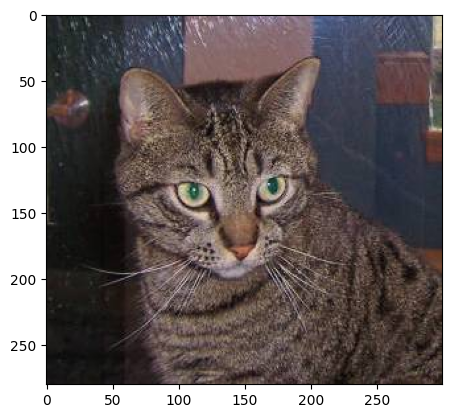

In [ ]:
img = Image.open(os.path.join(LOCAL_DIR, 'dataset', 'train', '0 - cats', 'cat.1.jpg'))
plt.imshow(img);

Построение модели:

In [ ]:
model = Sequential()
model.add(Input(shape=(150, 150, 3)))   # указываем размер входных изображений - 150 х 150, 3 цветовых канала
model.add(Conv2D(32, (3, 3), activation='relu',))
model.add(MaxPooling2D())
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [ ]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 15, 15, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │     3,211,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,453,121 (13.17 MB)

 Trainable params: 3,453,121 (13.17 MB)

 Non-trainable params: 0 (0.00 B)

Компиляция модели:

In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer=Adam(learning_rate=0.0002),
              metrics=['accuracy'])

Определение генераторов данных:

In [ ]:
# Сохраняем пути к папкам в переменные TRAIN_DIR, TEST_DIR
TRAIN_DIR = os.path.join(LOCAL_DIR, 'dataset/train')
TEST_DIR = os.path.join(LOCAL_DIR, 'dataset/test')

In [ ]:
# Определяем генераторы обучающих и тестовых данных,
# заодно и операции нормирования (1/255) и изменения размера (150 х 150)
train_datagen = ImageDataGenerator(rescale=1/255)
test_datagen = ImageDataGenerator(rescale=1/255)

train_generator = train_datagen.flow_from_directory(
        TRAIN_DIR,
        target_size=(150, 150),
        batch_size=100,
        class_mode='binary')

test_generator = test_datagen.flow_from_directory(
        TEST_DIR,
        target_size=(150, 150),
        batch_size=100,
        class_mode='binary')

Found 4000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [ ]:
# Убедимся, что данные имеют заданную размерность (batch_size, W, H, 3)
for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

data batch shape: (100, 150, 150, 3)
labels batch shape: (100,)


Обучение модели:

In [ ]:
history = model.fit(
      train_generator,
      validation_data=test_generator,
      steps_per_epoch=30,
      epochs=50
      )

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 18s 294ms/step - accuracy: 0.5427 - loss: 0.6943 - val_accuracy: 0.6150 - val_loss: 0.6787
Epoch 2/50
10/30 ━━━━━━━━━━━━━━━━━━━━ 3s 181ms/step - accuracy: 0.5519 - loss: 0.6798

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 107ms/step - accuracy: 0.5473 - loss: 0.6785 - val_accuracy: 0.6680 - val_loss: 0.6740
Epoch 3/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 6s 198ms/step - accuracy: 0.6085 - loss: 0.6642 - val_accuracy: 0.6670 - val_loss: 0.6107
Epoch 4/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 92ms/step - accuracy: 0.6117 - loss: 0.6445 - val_accuracy: 0.6800 - val_loss: 0.6195
Epoch 5/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 7s 228ms/step - accuracy: 0.6732 - loss: 0.6052 - val_accuracy: 0.7000 - val_loss: 0.5826
Epoch 6/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 90ms/step - accuracy: 0.6890 - loss: 0.5861 - val_accuracy: 0.7160 - val_loss: 0.5803
Epoch 7/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 7s 247ms/step - accuracy: 0.7301 - loss: 0.5566 - val_accuracy: 0.6910 - val_loss: 0.5679
Epoch 8/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 92ms/step - accuracy: 0.7257 - loss: 0.5563 - val_accuracy: 0.6830 - val_loss: 0.5722
Epoch 9/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 6s 204ms/step - accuracy: 0.7457 - loss: 0.5116 - val_accuracy: 0.7340 - val_los

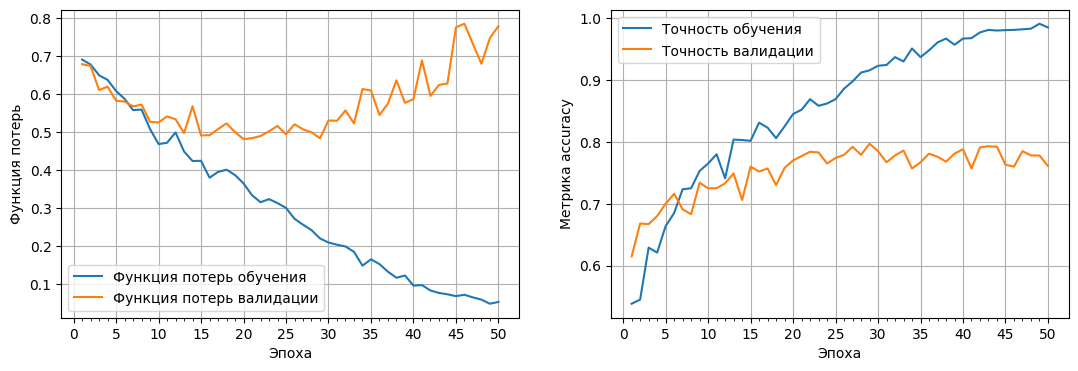

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(13, 4))
axs[0].plot(np.arange(1, len(history.history['loss']) + 1), history.history['loss'][:], label='Функция потерь обучения')
axs[0].plot(np.arange(1, len(history.history['loss']) + 1), history.history['val_loss'][:], label='Функция потерь валидации')
axs[0].grid()
axs[0].set_xticks(np.arange(0, len(history.history['loss']) + 1, 5))
axs[0].set_xticks(np.arange(0, len(history.history['loss']) + 1, 1), minor=True)
axs[0].legend(prop={'size': 10})
axs[0].set_xlabel('Эпоха')
axs[0].set_ylabel('Функция потерь')

axs[1].plot(np.arange(1, len(history.history['accuracy']) + 1), history.history['accuracy'][:], label='Точность обучения')
axs[1].plot(np.arange(1, len(history.history['accuracy']) + 1), history.history['val_accuracy'][:], label='Точность валидации')
axs[1].grid()
axs[1].set_xticks(np.arange(0, len(history.history['accuracy']) + 1, 5))
axs[1].set_xticks(np.arange(0, len(history.history['accuracy']) + 1, 1), minor=True)
# axs[1].set_yticks(np.arange(0.88, 1.01, 0.01))
axs[1].legend(prop={'size': 10})
axs[1].set_xlabel('Эпоха')
axs[1].set_ylabel('Метрика accuracy')
plt.show()

Проверка модели на произвольных фотографиях:

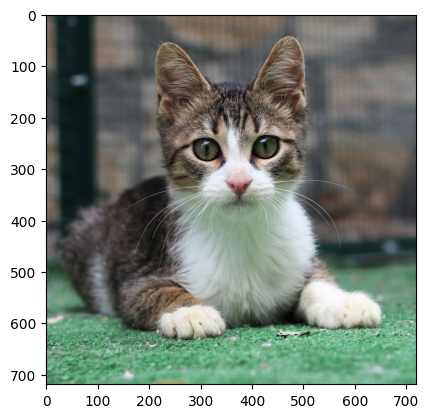

In [ ]:
# Файл cat.png должен быть в сессионном хранилище
image = Image.open('cat.jpg')
plt.imshow(image);

In [ ]:
# Изменение размера
image = image.resize((150, 150))

In [ ]:
# Преобразование к формату массива NumPy и добавление 1 (мини-батч из 1 элемента) к размерности
image = np.array(image).reshape((1, 150, 150, 3))

In [ ]:
# Проверка полученной размерности - должна быть (1, W, H, 3)
image.shape

(1, 150, 150, 3)

In [ ]:
# Значение 0 соответствует классу Коты
print(model.predict(image, verbose=False).round(3))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
[[0.]]


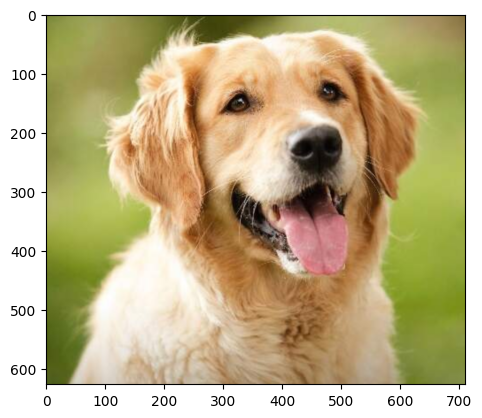

In [ ]:
# Попробуем изображение собаки
image = Image.open('dog.png')
plt.imshow(image);

In [ ]:
# Изменение размера
image = image.resize((150, 150))

In [ ]:
# Преобразование к массиву NumPy и изменение размерности
image = np.array(image).reshape((1, 150, 150, 3))

In [ ]:
# Проверка полученной размерности
image.shape

(1, 150, 150, 3)

In [ ]:
# Значение 1 соответствует классу Собаки
print(model.predict(image, verbose=False).round(3))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
[[1.]]


Сохранение модели и ее использование в других проектах:

In [ ]:
# Сохранение модели в файл
model.save('model.keras')

In [ ]:
# Загрузка модели из того же файла в другой проект
from tensorflow.keras.models import load_model
model_other_project = load_model('model.keras')

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 26 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
# Загружаем изображение для распознавания
image = Image.open('cat.png')
image = image.resize((150, 150))
image = np.array(image).reshape((1, 150, 150, 3))

# Прогон изображения через модель и получение результата распознавания. 0 - кот, 1 - собака
print(model_other_project.predict(image, verbose=False).round(0))

[[0.]]


## Нормализация (BatchNormalization) и Dropout

In [ ]:
# Добавим в модель слои BatchNormalization и Dropout
model = Sequential()
model.add(Input(shape=(150, 150, 3)))
model.add(Conv2D(32, (3, 3), activation='relu',))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())                      # BatchNormalization
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(rate=0.3))                         # Dropout
model.add(Dense(1, activation='sigmoid'))

In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer=Adam(learning_rate=0.0002),
              metrics=['accuracy'])

In [ ]:
history = model.fit(
      train_generator,
      steps_per_epoch=50,
      epochs=30,
      validation_data=test_generator)

Epoch 1/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 13s 177ms/step - accuracy: 0.5390 - loss: 0.8384 - val_accuracy: 0.5630 - val_loss: 0.6897
Epoch 2/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 17s 150ms/step - accuracy: 0.6558 - loss: 0.6208 - val_accuracy: 0.6160 - val_loss: 0.6809
Epoch 3/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 8s 166ms/step - accuracy: 0.7018 - loss: 0.5728 - val_accuracy: 0.6860 - val_loss: 0.6700
Epoch 4/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 10s 162ms/step - accuracy: 0.7515 - loss: 0.5061 - val_accuracy: 0.7250 - val_loss: 0.6501
Epoch 5/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 11s 171ms/step - accuracy: 0.7902 - loss: 0.4530 - val_accuracy: 0.7260 - val_loss: 0.6285
Epoch 6/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 9s 177ms/step - accuracy: 0.8344 - loss: 0.3863 - val_accuracy: 0.7310 - val_loss: 0.6083
Epoch 7/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 10s 170ms/step - accuracy: 0.8761 - loss: 0.3105 - val_accuracy: 0.7450 - val_loss: 0.5858
Epoch 8/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 8s 163ms/step - accuracy: 0.8955 - loss: 0.2741 - val_accurac

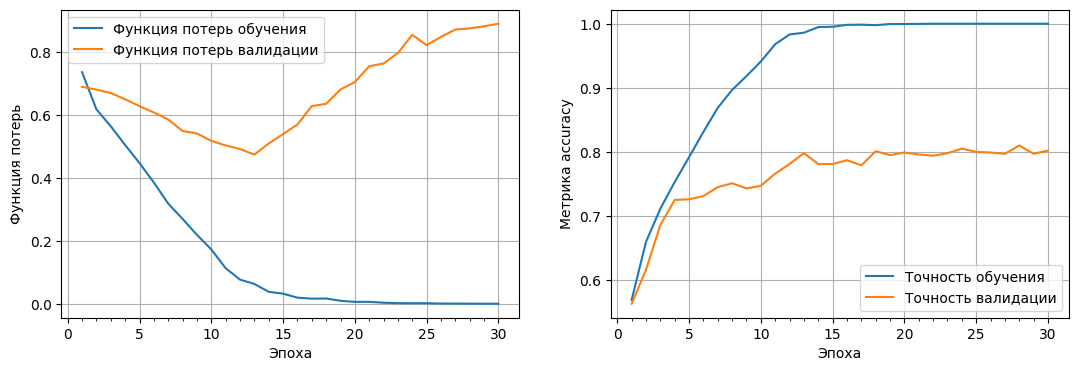

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(13, 4))
axs[0].plot(np.arange(1, len(history.history['loss']) + 1), history.history['loss'][:], label='Функция потерь обучения')
axs[0].plot(np.arange(1, len(history.history['loss']) + 1), history.history['val_loss'][:], label='Функция потерь валидации')
axs[0].grid()
axs[0].set_xticks(np.arange(0, len(history.history['loss']) + 1, 5))
axs[0].set_xticks(np.arange(0, len(history.history['loss']) + 1, 1), minor=True)
axs[0].legend(prop={'size': 10})
axs[0].set_xlabel('Эпоха')
axs[0].set_ylabel('Функция потерь')

axs[1].plot(np.arange(1, len(history.history['accuracy']) + 1), history.history['accuracy'][:], label='Точность обучения')
axs[1].plot(np.arange(1, len(history.history['accuracy']) + 1), history.history['val_accuracy'][:], label='Точность валидации')
axs[1].grid()
axs[1].set_xticks(np.arange(0, len(history.history['accuracy']) + 1, 5))
axs[1].set_xticks(np.arange(0, len(history.history['accuracy']) + 1, 1), minor=True)
# axs[1].set_yticks(np.arange(0.88, 1.01, 0.01))
axs[1].legend(prop={'size': 10})
axs[1].set_xlabel('Эпоха')
axs[1].set_ylabel('Метрика accuracy')
plt.show()

За меньшее количество эпох достигнута чуть большая точность, стабилизировалась динамика метрики accruacy. Наблюдается сильное переобучение.

## Аугментация данных

In [ ]:
# Добавим преобразования аугментации в генератор обучающих данных.
train_datagen = ImageDataGenerator(rescale=1/255,
                                   rotation_range=10,   # повороты
                                   width_shift_range=0.1,  # сдвиги по горизонтали
                                   height_shift_range=0.1, # сдвиги по вертикали
                                   shear_range=0.1,       # искажение "параллелограмм"
                                   zoom_range=0.1,         # увеличение и уменьшение
                                   horizontal_flip=True,    # зеркальное отражение по горизонтали
                                   fill_mode='nearest'
                                  )
test_datagen = ImageDataGenerator(rescale=1/255)  # для генератора тестовых данных аугментация не применяется

train_generator = train_datagen.flow_from_directory(
        TRAIN_DIR,
        target_size=(150, 150),
        batch_size=100,
        class_mode='binary')

test_generator = test_datagen.flow_from_directory(
        TEST_DIR,
        target_size=(150, 150),
        batch_size=100,
        class_mode='binary')

Found 4000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [ ]:
# Остальной код без изменений
model = Sequential()
model.add(Input(shape=(150, 150, 3)))
model.add(Conv2D(32, (3, 3), activation='relu',))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [ ]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                    │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 34, 34, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 15, 15, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 6272)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 512)                 │       3,211,776 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             513 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,453,121 (13.17 MB)

 Trainable params: 3,453,121 (13.17 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer=Adam(learning_rate=0.0002),
              metrics=['accuracy'])

In [ ]:
history = model.fit(
      train_generator,
      steps_per_epoch=50,
      epochs=170,
      validation_data=test_generator)

Epoch 1/20
40/50 ━━━━━━━━━━━━━━━━━━━━ 5s 543ms/step - accuracy: 0.8491 - loss: 0.3516

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


50/50 ━━━━━━━━━━━━━━━━━━━━ 28s 467ms/step - accuracy: 0.8486 - loss: 0.3514 - val_accuracy: 0.8020 - val_loss: 0.3883
Epoch 2/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 27s 460ms/step - accuracy: 0.8548 - loss: 0.3460 - val_accuracy: 0.7970 - val_loss: 0.4030
Epoch 3/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 27s 465ms/step - accuracy: 0.8354 - loss: 0.3650 - val_accuracy: 0.8020 - val_loss: 0.3982
Epoch 4/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 27s 465ms/step - accuracy: 0.8540 - loss: 0.3427 - val_accuracy: 0.8030 - val_loss: 0.4019
Epoch 5/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 27s 466ms/step - accuracy: 0.8333 - loss: 0.3747 - val_accuracy: 0.8070 - val_loss: 0.3838
Epoch 6/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 41s 453ms/step - accuracy: 0.8356 - loss: 0.3602 - val_accuracy: 0.8000 - val_loss: 0.3938
Epoch 7/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 27s 454ms/step - accuracy: 0.8469 - loss: 0.3417 - val_accuracy: 0.8040 - val_loss: 0.3937
Epoch 8/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 27s 461ms/step - accuracy: 0.8405 - loss: 0.3490 - val_accuracy: 0.810

In [ ]:
history.history['loss'] = history.history['loss'] + history5.history['loss']
history.history['val_loss'] = history.history['val_loss'] + history5.history['val_loss']
history.history['accuracy'] = history.history['accuracy'] + history5.history['accuracy']
history.history['val_accuracy'] = history.history['val_accuracy'] + history5.history['val_accuracy']

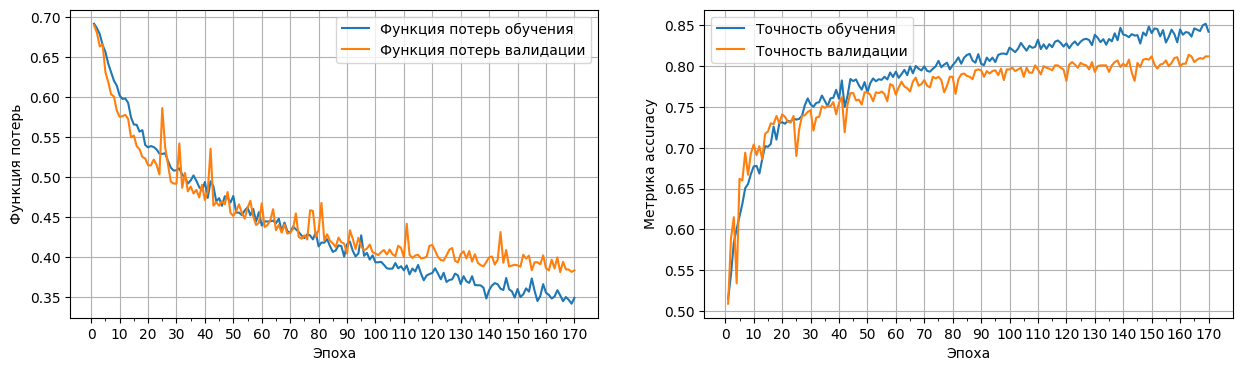

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(15, 4))
axs[0].plot(np.arange(1, len(history.history['loss']) + 1), history.history['loss'][:], label='Функция потерь обучения')
axs[0].plot(np.arange(1, len(history.history['loss']) + 1), history.history['val_loss'][:], label='Функция потерь валидации')
axs[0].grid()
axs[0].set_xticks(np.arange(0, len(history.history['loss']) + 1, 10))
axs[0].set_xticks(np.arange(0, len(history.history['loss']) + 1, 5), minor=True)
axs[0].legend(prop={'size': 10})
axs[0].set_xlabel('Эпоха')
axs[0].set_ylabel('Функция потерь')

axs[1].plot(np.arange(1, len(history.history['accuracy']) + 1), history.history['accuracy'][:], label='Точность обучения')
axs[1].plot(np.arange(1, len(history.history['accuracy']) + 1), history.history['val_accuracy'][:], label='Точность валидации')
axs[1].grid()
axs[1].set_xticks(np.arange(0, len(history.history['accuracy']) + 1, 10))
axs[1].set_xticks(np.arange(0, len(history.history['accuracy']) + 1, 5), minor=True)
# axs[1].set_yticks(np.arange(0.88, 1.01, 0.01))
axs[1].legend(prop={'size': 10})
axs[1].set_xlabel('Эпоха')
axs[1].set_ylabel('Метрика accuracy')
plt.show()

Немного увеличилась точность и значительно уменьшилось переобучение.